# A nonsensical approach

I spent some time thinking of ways to recommend flavor profiles. Two non-trivial approaches I considered were implementing a Markov chain or utilizing machine learning. In a Markov chain, we only consider our current state, i.e., an ingredient. And so whether or not we've already considered tofu, cilantro, and rice wouldn't have any effect our next state. It only matters that we are currently at rice. One way around this would be to have each state include it's previous states. So if I started at tofu, the next state could be tofu and cilantro (as oppsed to just cilantro), then the state after that could might be be tofu, cilantro, and soy sauce. But this soon becomes combintoarially expesnive and would probably be something on the order of n facotrial.

Another issue is that at no point would we ever return to a previous state. Translated in to a real world scenario, it would be as if I chose tofu, rice, cilantro, then changed my mind and returned back to rice. So because we would be absent of this property, we would essentially just end up with an upper triangular matrix. Admittedly though, it was still tempting to do.

Regarding a machine learing approach, implementing something like a neural network would require data that had a feature set. Aside from what had been paired with what (according to what we scraped), we didn't have features such as taste category, cooking technique, etc. This would have required far too much time.


Eventually I dropped the contraints. I thought to myself "Who cares if it makes sense?". (Below you'll see some interesting examples I found). I ended treating about the data as a graph, and thinking about a flavor profile as list, or more specifically, a path. At this point, it seemed Dijkstra's algorithm would be quite fiting.


I calculate all shortest paths for all nodes and store the results in a precomputed table. This would allow for faster return time, as calculating a path can be significantly slower than simple look up. Data is updated automated to update weekly, which is executed by a worker.


You can see my approach to ranking the ingredients [here](https://github.com/alberth8/PairingService/blob/beta/intersection.ipynb).


*Be warned* that the output of these functions is quite long, so feel free to just scroll pass them.

Thanks in advance to @aezed for scraping the data.


## Data manipulation

I used jupyter notebook to script and test my functions. One key advantage of jupyter notebook is ability to "test-as-you-go". Computations that are resource intensive are essentially memoized, improving work flow and reducing time that would otherwise be spent re-running a script.


Before we begin doing any of the network analysis, we first have to manipulate the recipe and ingredients data (a JSON object) in to an adjacency matrix. From there we can then perform Dijkstra's algorithm on each vertex, finding all shortest paths in our graph.

## JSON

Our JSON file is an array of objects. Each object contains the key's `recipeTitle`, `recipeUrl`, `recipeImgUrl`, and `ingredients`. We are only interested in the ingredients associated with each recipe.

In [11]:
# Obtaining the list of ingredients for each recipe. Only interested
# in the ingredients, and so I've stripped the other information such as URL
import json

with open('data/combinedRecipes.JSON') as recipes:
    data = json.load(recipes)
# print(data)

ingrs_per_recipe = []
for obj in data:
    ingrs_per_recipe.append(obj["ingredients"])
print(ingrs_per_recipe)

[['cherries', 'lemon', 'lemon juice', 'sugar', 'salt', 'tapioca', 'egg', 'egg yolk', 'cream', 'heavy cream', 'cherry'], ['cloves', 'garlic', 'cumin', 'pepper', 'oregano', 'oranges', 'limes', 'olive', 'olive oil', 'salt', 'pork', 'mint', 'lime', 'beans', 'black beans', 'rice'], ['ponzu', 'shallot', 'mustard', 'olive', 'olive oil', 'wasabi', 'steak', 'cucumber', 'salt'], ['rice', 'rice vinegar', 'vinegar', 'lemon', 'lime', 'lime juice', 'soy sauce'], ['paprika', 'brown sugar', 'sugar', 'salt', 'mustard', 'seed', 'garlic', 'garlic powder', 'onion', 'onion powder', 'oregano', 'coriander', 'cumin', 'pepper', 'red pepper', 'red pepper flakes', 'ketchup', 'molasses', 'worcestershire sauce', 'apple', 'apple cider vinegar', 'cider', 'vinegar', 'pork'], ['flour', 'sugar', 'salt', 'butter', 'water'], ['pepper', 'poblano', 'poblano pepper', 'salt', 'vinegar', 'white vinegar', 'onion', 'red onion', 'thyme', 'cilantro', 'parsley'], ['lemons', 'sugar', 'tea'], ['lemons', 'sugar', 'water'], ['water', 

## Food List

This is the "dictionary" from which we will parse our data against. This list was built manually from food.com. While it is not exhaustive, it is more than sufficient to provide a detailed analysis.

In [14]:
# getting the list of ingredients, lowercasing, uniqifying, then sorting alphabetically
with open('data/foodList.txt') as f:
        ing_list = f.readlines()
ing_list = [ing[:-1].lower() for ing in ing_list]
uniq_ing_list = list(set(ing_list)) # had 3 duplicates
uniq_ing_list = sorted(uniq_ing_list)
print(len(uniq_ing_list))
# print(uniq_ing_list)
# print('fennel seeds' in uniq_ing_list)

1024


## Adjacency Matrix Part 1

In the cell below we create an n x n data frame where each cell contains the number of times a 

In [15]:
import pandas as pd
import itertools as iter
import numpy as np

columns = uniq_ing_list
print(len(columns))
df = pd.DataFrame(0, index=columns, columns=columns)
count = 0

for ingredient_list in ingrs_per_recipe:
    for pair in list(iter.permutations(ingredient_list,2)):
        try: 
            count += 1
            r = pair[0]
            c = pair[1]
            curr_value = df.loc[r, c]
            new_value = curr_value + 1
            df.ix[r, c] = new_value
        except KeyError as key_err:
            print('Could not find key in foodList:', key_err)

# diagonal should be set to 0 because no such case that 
# apples will be paired with apples
df.values[[np.arange(len(columns))]*2] = 0

1024


## Sanity check

The data frame is far too large to view and examine visually. So there are a few key properties I examined for:
 1. the dataframe should be symmetric
 2. column and row labels should be identical
 3. diagonal should sum to zero

In [6]:
#
# Sanity checks: 
#
# 1. check for symmetry A^T = A
# np.diag(df).sum() # -> 0
# dfT = df.transpose()
# print((dfT == df).all().sum()) # if sums to len(columns), then it is symmetric
# print(len((dfT == df).all()))

# 2. check if row and col labels are the same
# list(df.columns.values) == list(df.index.values) -> true

## Adjacency Matrix Part 2

Removing zero-valued columns and rows is to remove ingredients that didn't appear in our scraped recipes. These are essentially isolated nodes.

In [16]:
# Now need to remove row and columns that have all 0s
df = df.loc[:, (df != 0).any(axis=0)]
df = df.loc[(df != 0).any(axis=1), :]
print(df.shape) # -> (371, 371)

# convert values to probability
all = df.sum().sum() # total sum of df
print('TOTAL', all)
df = df.divide(float(-all)).add(1)
df = df.replace(1.0, 0.0)
print(df)

# get new column names, will need later
new_cols = list(df.columns.values)
print(new_cols)

(401, 401)
TOTAL 68458
                       absinthe     adobo  ale  allspice    almond  \
absinthe                    0.0  0.000000  0.0  0.000000  0.000000   
adobo                       0.0  0.000000  0.0  0.000000  0.000000   
ale                         0.0  0.000000  0.0  0.000000  0.000000   
allspice                    0.0  0.000000  0.0  0.000000  0.000000   
almond                      0.0  0.000000  0.0  0.000000  0.000000   
almond butter               0.0  0.000000  0.0  0.000000  0.999985   
almond extract              0.0  0.000000  0.0  0.000000  0.999985   
almonds                     0.0  0.000000  0.0  0.000000  0.000000   
anchovy                     0.0  0.000000  0.0  0.000000  0.000000   
apple                       0.0  0.000000  0.0  0.999985  0.000000   
apple cider vinegar         0.0  0.000000  0.0  0.000000  0.000000   
apple pie spice             0.0  0.000000  0.0  0.000000  0.000000   
apples                      0.0  0.000000  0.0  0.000000  0.000000 

## Dijkstras

And now the fun begins! This is the initial testing of finding all shortest paths. The implmentation follows the canonical algorithm that uses a priority queue. However, instead of using a weighing function, I simply use the values stored at `Adj_{i, j}`. Python's heapq doesn't include a decrease-key function, so the decrease-key segment runs at worst in linear time. I soon plan on replacing this with a pairing heap to avoid this drawback.

In the output, beginning at some end node, we can trace our way back to a source node.

In [17]:
import math
from heapq import *

def Dijkstras(AdjMat, start):
    # Initialize single source
    dist = {}
    prev = {}
    Q = []
    for v in list(AdjMat.columns.values):
        if v == start:
            dist[v] = 0
        else:
            dist[v] = math.inf
            prev[v] = 'NO NEIGHBOR'
        heappush(Q, [ dist[v], v ])
        
    while Q:
        thru_me = heappop(Q)[1]
        for neighbor in list(AdjMat.index[(AdjMat > 0)[thru_me]]): 
            new_path_dist = dist[thru_me] + AdjMat.loc[thru_me, neighbor] # matrix is symmetric
            # Relaxtion
            if new_path_dist < dist[neighbor]:
                dist[neighbor] = new_path_dist
                prev[neighbor] = thru_me
                # Decrease priority
                for node in Q:
                    if node[1] == neighbor:
                        node[0] = new_path_dist

                        
    print             
    return {'dist': dist, 'prev': prev}

D = Dijkstras(df, 'absinthe')
Dijkstra_paths = D['prev']
print(Dijkstra_paths)
print(len(Dijkstra_paths))
# D_dist = D['dist']

{'wasabi': 'water', 'bean': 'water', 'peanut': 'sugar', 'pickle': 'sour cream', 'rotisserie': 'sour cream', 'apple pie spice': 'pumpkin', 'arrowroot': 'tomato', 'pea': 'water', 'lemon': 'sugar', 'eggplant': 'water', 'veal': 'salt', 'coriander': 'sugar', 'stuffing': 'water', 'sesame seeds': 'water', 'summer squash': 'salt', 'tabasco sauce': 'salt', 'balsamic vinegar': 'sugar', 'eggs': 'rum', 'tomato paste': 'water', 'habanero': 'limes', 'poblano': 'salt', 'snow peas': 'sugar', 'pecans': 'vanilla', 'oatmeal': 'sugar', 'spaetzle': 'sour cream', 'sweet potatoes': 'sugar', 'mayo': 'sour cream', 'chocolate': 'rum', 'lime': 'rum', 'cocoa': 'vanilla', 'egg substitute': 'salt', 'venison': 'sour cream', 'beer': 'sugar', 'dill': 'sour cream', 'hamburger': 'milk', 'bacon': 'water', 'cream cheese': 'sugar', 'rhubarb': 'sugar', 'poblano pepper': 'salt', 'pumpkin seeds': 'sour cream', 'fava bean': 'salt', 'mango': 'lime', 'seeds': 'sugar', 'thyme': 'water', 'molasses': 'sugar', 'ground turkey': 'wate

## Obtain path

We recursively call `get_path()` in order to trace all paths leading back to the source node. In experimenting, some interesting paths / recommendations I found were ['fish sauce', 'sugar', 'rum', 'absinthe’] and ['octopus', 'chilli', 'apple']. These results are not incorrect. The fact that they are considered one path, does not mean they have been commonly paired together as a whole, it simply means, for example, that octopus and chilli were paired in a number of recipes, and separately, chilli and apple were. And, thus, through chilli, otopus and apple are related.

The error below is intentional. The observant reader will have noticed that in the above output, ale had no neighbor (`'ale': 'NO NEIGHBOR'`). 

In [20]:
# print(D_prev)
# We would loop through and `start` would be different every time.
# In this case, `end` is `apple`, but would be the vertex of the outer
# for loop.

def get_path(start, end, all_paths):
    def helper(start, end, start_to_end=[]):
        start_to_end.append(start)

        if (start == end):
#             print('returned')
            return start_to_end;

#         print(start)
#         print(all_paths[start])
        next = all_paths[start]
        return helper(next, end, start_to_end)

    return {'start': start, 'end': end, 'path': helper(start, end)}
    
a_b = get_path('ale', 'absinthe', Dijkstra_paths)
print(a_b)

KeyError: 'NO NEIGHBOR'

## All paths

Below we test for a single case. I discovered that the previous nodes of some nodes were not being over written, because of their lack of connectivity with other ingredients.

In [171]:
table = {}
for source in ['absinthe']:  # perform dijkstras on every single node
    temp = {}  # will store all paths from an ingredient to the source
    paths_to_source = Dijkstras(df, source)['prev']  # finds all shortest paths going to source node
    for i in paths_to_source:  
        print('---- i is -----', i)
        temp[i] = get_path(i, source, paths_to_source)['path']
        print('has path', temp[i])
    table[source] = temp
    print('TABLE:', table)
print(table)

---- i is ----- tomato paste
has path ['tomato paste', 'water', 'rum', 'absinthe']
---- i is ----- bacon
has path ['bacon', 'water', 'rum', 'absinthe']
---- i is ----- seeds
has path ['seeds', 'sugar', 'rum', 'absinthe']
---- i is ----- kalamata olives
has path ['kalamata olives', 'olive', 'water', 'rum', 'absinthe']
---- i is ----- eggplant
has path ['eggplant', 'water', 'rum', 'absinthe']
---- i is ----- fennel
has path ['fennel', 'sugar', 'rum', 'absinthe']
---- i is ----- summer squash
has path ['summer squash', 'salt', 'water', 'rum', 'absinthe']
---- i is ----- radishes
has path ['radishes', 'salt', 'water', 'rum', 'absinthe']
---- i is ----- vanilla
has path ['vanilla', 'rum', 'absinthe']
---- i is ----- rice wine
has path ['rice wine', 'water', 'rum', 'absinthe']
---- i is ----- bread
has path ['bread', 'water', 'rum', 'absinthe']
---- i is ----- seed
has path ['seed', 'sugar', 'rum', 'absinthe']
---- i is ----- vanilla extract
has path ['vanilla extract', 'vanilla', 'rum', 'ab

KeyError: None

## Heat map

Oh, MATLAB. It's always fun to play with matplotlib. Here's a visual representation of the pre-processed adjacency matrix.

<IPython.core.display.Javascript object>


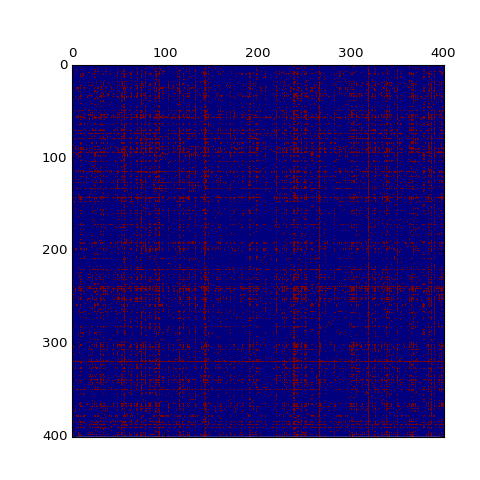

In [9]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

nparray = df.as_matrix()
plt.matshow(nparray, interpolation='none')

Please see my github page for the final implementation. Thanks for reading :)